In [1]:
#https://github.com/pomber/covid19
print('Initializing brazilian prediction!')
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv('../data/world_corona19_data.csv', sep=',')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
dayAfterTomorrow = str(df.date.max().date() + datetime.timedelta(days=2))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))
daysToPredict = 10

df[df['country']=='Brazil'].tail()

,country,date,cases,deaths,recoveries,day,case_day,death_day,recovery_day,%var_case_day,...,recoveries_million,avg7_cases,avg7_deaths,avg7_recoveries,avg7_cases_million,avg7_deaths_million,avg7_recoveries_million,perc_death,perc_recovery,active_cases
1048,Brazil,2020-04-14,25262,1532,3046,49,1832,204,2873,47.98,...,13.6,1604.0,120.0,417.0,7.0,0.0,1.0,6.06,12.06,20684
1049,Brazil,2020-04-15,28320,1736,14026,50,3058,204,10980,66.92,...,52.0,1735.0,131.0,1985.0,8.0,0.0,9.0,6.13,49.53,12558
1050,Brazil,2020-04-16,30425,1924,14026,51,2105,188,0,-31.16,...,0.0,1761.0,139.0,1979.0,8.0,0.0,9.0,6.32,46.10,14475
1051,Brazil,2020-04-17,33682,2141,14026,52,3257,217,0,54.73,...,0.0,2006.0,154.0,1979.0,9.0,0.0,9.0,6.36,41.64,17515
1052,Brazil,2020-04-18,36658,2354,14026,53,2976,213,0,-8.63,...,0.0,2275.0,175.0,1979.0,10.0,0.0,9.0,6.42,38.26,20278


In [3]:
countries = df['country'].unique()
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

----------------------------
### Predicting cases and death for a selected country

#### selecting a country for prediction

In [4]:
#inform the countries for predictions
predictedCountries = ['Brazil']

In [137]:
df_diario = pd.DataFrame(columns=['country','ds', 'case_day', 'death_day', 'cases', 'deaths'])


for country in predictedCountries:
    # preparing dataset for predictions
    df_country = df.loc[df['country'] == country][['date','country','case_day','death_day']]
    df_country.rename(columns={'date': 'ds'}, inplace= True)
    df_cases = df_country.loc[:,['ds','case_day']]
    df_cases.rename(columns={'case_day':'y'}, inplace =True)
    
    capCases =  df_cases['y'].max() * 2
    df_cases['cap'] = capCases
    
    df_deaths = df_country.loc[:,['ds','death_day']]
    df_deaths.rename(columns={'death_day':'y'}, inplace =True)
    
    capDeaths = df_deaths['y'].max() * 2
    df_deaths['cap'] = capDeaths
    
    # fiting the model and making prediction
    m_cases = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='logistic')
    m_cases.fit(df_cases)
    m_deaths = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='logistic')
    m_deaths.fit(df_deaths)
    
    future_cases = m_cases.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    future_cases['cap'] = capCases
    future_cases['floor'] = 0
    future_deaths = m_deaths.make_future_dataframe(periods=daysToPredict, freq='D', include_history=False)
    future_deaths['cap'] = capDeaths
    future_deaths['floor'] = 0
    
    forecast_cases = m_cases.predict(future_cases)
    forecast_deaths = m_deaths.predict(future_deaths)
        
    p = forecast_cases.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    t = df_cases.append(p[['ds','y']], ignore_index=True)
#     t= p 
    p = forecast_deaths.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
    s = df_deaths.append(p[['ds','y']], ignore_index=True)
#     s = p
    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'case_day'}, inplace= True)
    t['case_day'] = t['case_day'].astype('int32')
    t['cases'] = t['case_day'].cumsum().astype('int32')
    t['death_day'] = s['y'].astype('int32')
    t['deaths'] = t['death_day'].cumsum().astype('int32')
    t['country'] = country
    t['predicted?'] = t['ds'] > today # para separar o que é previsão (True) do que é dado real (False)
    df_diario = df_diario.append(t)
    
# # df_prediction.to_csv('../predictions/worldPrediction_' + today + '.csv', index = False)
df_diario.tail(15)

,country,ds,case_day,death_day,cases,deaths,cap,predicted?
48,Brazil,2020-04-14,1832,204,25262,1532,6514.0,False
49,Brazil,2020-04-15,3058,204,28320,1736,6514.0,False
50,Brazil,2020-04-16,2105,188,30425,1924,6514.0,False
51,Brazil,2020-04-17,3257,217,33682,2141,6514.0,False
52,Brazil,2020-04-18,2976,213,36658,2354,6514.0,False
53,Brazil,2020-04-19,2859,224,39517,2578,NaN,True
54,Brazil,2020-04-20,2956,240,42473,2818,NaN,True
55,Brazil,2020-04-21,3394,274,45867,3092,NaN,True
56,Brazil,2020-04-22,3669,283,49536,3375,NaN,True
57,Brazil,2020-04-23,3685,296,53221,3671,NaN,True


In [50]:
forecast_cases['yhat'].tail()

58    3866.250696
59    3910.915662
60    3992.599057
61    4076.686813
62    4495.468005
Name: yhat, dtype: float64

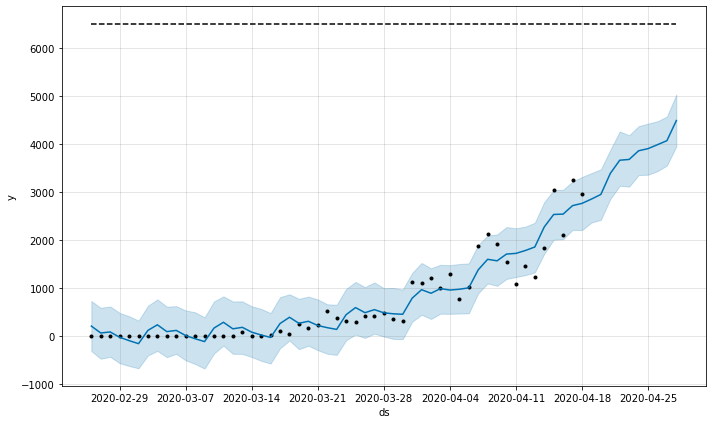

In [68]:
fig = m_cases.plot(forecast_cases)    

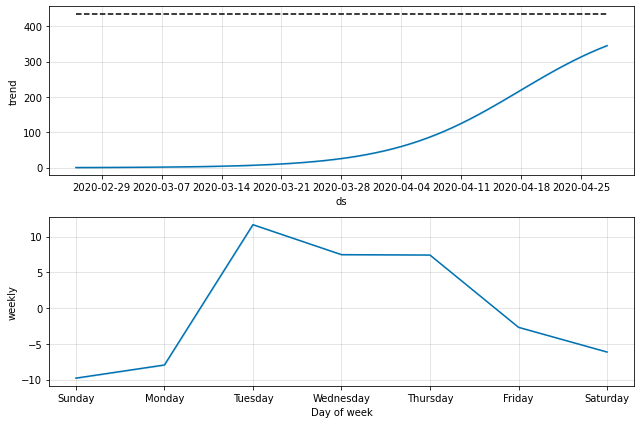

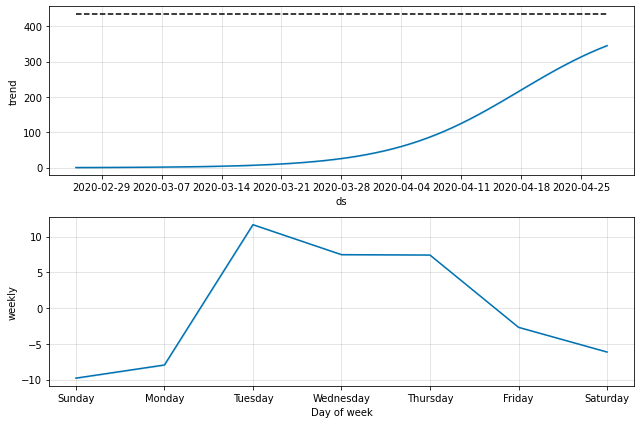

In [31]:
m_deaths.plot_components(forecast_deaths)

In [6]:
df_prediction.loc[df_prediction['ds']==tomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
53,Brazil,2020-04-19,2166,122,38824,2476,True


In [7]:
df_prediction.loc[df_prediction['ds']==dayAfterTomorrow]

,country,ds,case_day,death_day,cases,deaths,predicted?
54,Brazil,2020-04-20,2174,128,40998,2604,True


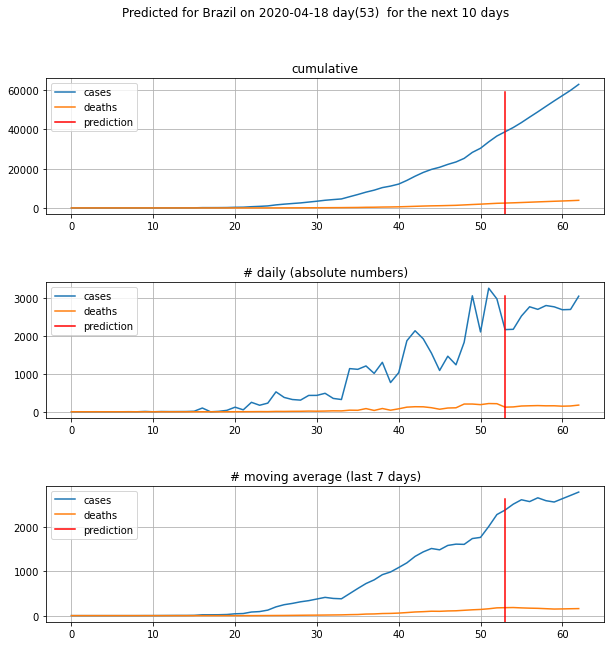

In [8]:
df_br = df_prediction.loc[df_prediction['country']=='Brazil']
df_br.reset_index(0, inplace=True)

x = df_br.index
corte = df_br.loc[df_br.ds == str(today)].index[0]+1

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))
fig.suptitle('Predicted for ' + df_br.country[0] + ' on ' + today + ' day('+ str(corte) +') ' + ' for the next ' + str(daysToPredict) + ' days')
fig.subplots_adjust(hspace = 0.5)
ax1.set_title('cumulative')
ax1.plot(x, df_br['cases'], label = 'cases')#, linewidths = 0.01)
ax1.plot(x, df_br['deaths'], label = 'deaths')
ax1.grid()
ax1.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax1.legend()

ax2.set_title('# daily (absolute numbers)')
ax2.plot(x, df_br['case_day'], label = 'cases')
ax2.plot(x, df_br['death_day'], label = 'deaths')
ax2.grid()
ax2.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax2.legend()

avg7_cases_million = df_br['case_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')
avg7_death_million = df_br['death_day'].rolling(window=7).mean().replace([np.inf, -np.inf], 0).replace([np.nan], 0).astype('int')

ax3.set_title('# moving average (last 7 days)')
ax3.plot(x, avg7_cases_million, label = 'cases')
ax3.plot(x, avg7_death_million, label = 'deaths')
ax3.grid()
ax3.axvline(x=corte, ymin=0, ymax=0.9, color = 'red', label = 'prediction')
ax3.legend()

# plt.savefig('../predictions/brazil_predictions.png')

In [145]:
df_acumulado = pd.DataFrame(columns=['country','ds', 'case_day', 'death_day', 'cases', 'deaths'])
daysToPredict = 10

for country in predictedCountries:
    # preparing dataset for predictions
    df_country = df.loc[df['country'] == country][['date','country','cases','deaths']]
    df_country.rename(columns={'date': 'ds'}, inplace= True)
    df_cases = df_country.loc[:,['ds','cases']]
    df_cases.rename(columns={'cases':'y'}, inplace =True)
    
    capCases =  64099#df_cases['y'].max() * 2
    df_cases['cap'] = capCases
    df_cases['floor'] = 0
    
    df_deaths = df_country.loc[:,['ds','deaths']]
    df_deaths.rename(columns={'deaths':'y'}, inplace =True)
    capDeaths = df_deaths['y'].max() * 2
    df_deaths['cap'] = capDeaths
    df_deaths['floor'] = 0

    # fiting the model and making prediction
    m_cases = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='logistic')
    m_cases.fit(df_cases)
    m_deaths = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95, growth='logistic')
    m_deaths.fit(df_deaths)
    
    future_cases = m_cases.make_future_dataframe(periods=daysToPredict, freq='D', include_history=True)
    future_cases['cap'] = capCases
    future_cases['floor'] = 0
    future_deaths = m_deaths.make_future_dataframe(periods=daysToPredict, freq='D', include_history=True)
    future_deaths['cap'] = capDeaths
    future_deaths['floor'] = 0
    forecast_cases = m_cases.predict(future_cases)
    forecast_deaths = m_deaths.predict(future_deaths)

        
    p = forecast_cases.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
#     t = df_cases.append(p[['ds','y']], ignore_index=True)
    t= p
    
    p = forecast_deaths.loc[:,['ds','yhat']]
    p.rename(columns={'yhat': 'y'}, inplace= True)
#     s = df_deaths.append(p[['ds','y']], ignore_index=True)
    s = p
    t.fillna(0, inplace=True)
    s.fillna(0,inplace=True)
    t['ds'] = t['ds'].astype('datetime64[ns]')
    t.rename(columns={'y': 'cases'}, inplace= True)
    t['cases'] = t['cases'].astype('int32')
    t['case_day'] = t['cases'].diff()#.astype('int32')
    t['deaths'] = s['y'].astype('int32')
    t['death_day'] = t['deaths'].diff()#.astype('int32')
    t['country'] = country
    t['predicted?'] = t['ds'] > today # para separar o que é previsão (True) do que é dado real (False)
    df_acumulado = df_acumulado.append(t)
    
# # df_prediction.to_csv('../predictions/worldPrediction_' + today + '.csv', index = False)
df_acumulado.tail(15)

,country,ds,case_day,death_day,cases,deaths,predicted?
48,Brazil,2020-04-14,2210.0,178.0,26514,1573,False
49,Brazil,2020-04-15,2400.0,184.0,28914,1757,False
50,Brazil,2020-04-16,2279.0,191.0,31193,1948,False
51,Brazil,2020-04-17,2324.0,188.0,33517,2136,False
52,Brazil,2020-04-18,2220.0,189.0,35737,2325,False
53,Brazil,2020-04-19,1905.0,177.0,37642,2502,True
54,Brazil,2020-04-20,1922.0,182.0,39564,2684,True
55,Brazil,2020-04-21,2130.0,197.0,41694,2881,True
56,Brazil,2020-04-22,2186.0,187.0,43880,3068,True
57,Brazil,2020-04-23,1937.0,178.0,45817,3246,True


In [146]:
forecast_cases[['ds','yhat']].tail()

,ds,yhat
58,2020-04-24,47683.097141
59,2020-04-25,49342.662020
60,2020-04-26,50603.030433
61,2020-04-27,51813.829317
62,2020-04-28,53187.019928


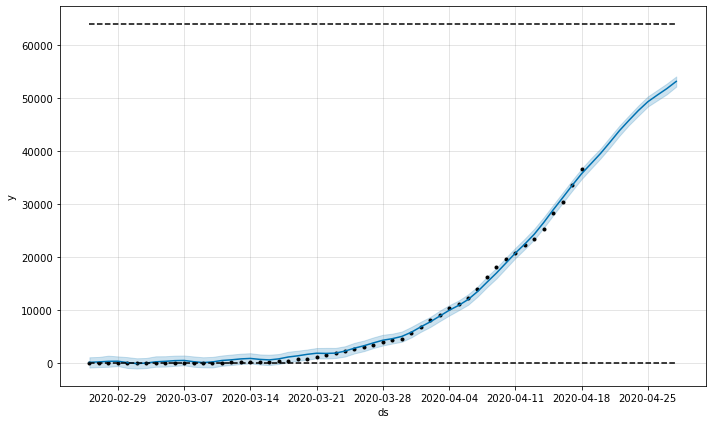

In [147]:
fig = m_cases.plot(forecast_cases)
# m_deaths.plot(forecast_deaths)

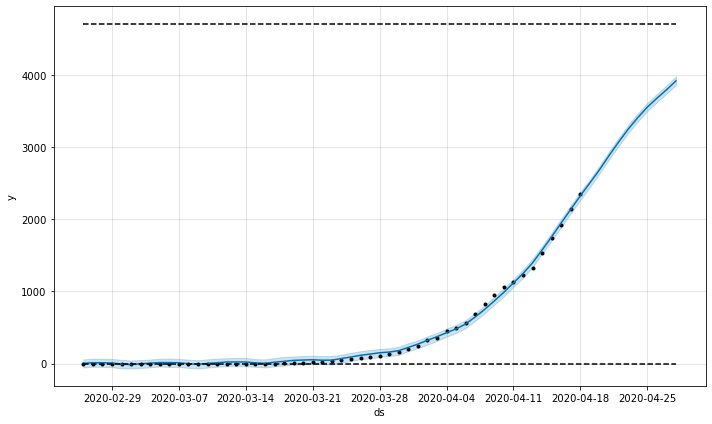

In [83]:
fig = m_deaths.plot(forecast_deaths)

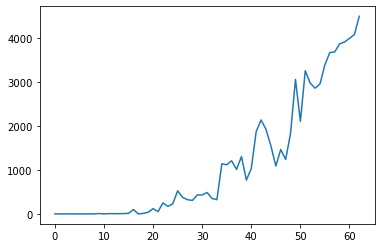

In [118]:
plt.plot(df_prediction['case_day'])

In [117]:
df_prediction[['cases','case_day']].head(10)

,cases,case_day
0,1,1
1,1,0
2,1,0
3,2,1
4,2,0
5,2,0
6,2,0
7,4,2
8,4,0
9,13,9


In [93]:
forecast_cases[['ds','yhat']].head(10)

,ds,yhat
0,2020-02-26,107.790087
1,2020-02-27,173.541365
2,2020-02-28,271.967226
3,2020-02-29,273.970858
4,2020-03-01,81.523143
5,2020-03-02,-103.606128
6,2020-03-03,-9.841213
7,2020-03-04,219.790346
8,2020-03-05,301.279430
9,2020-03-06,417.644257


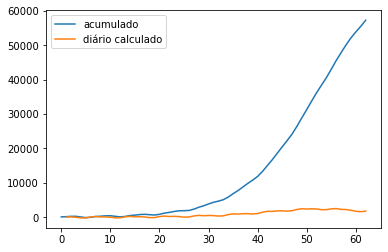

In [134]:
plt.plot(df_acumulado['cases'], label = 'acumulado')
plt.plot(df_acumulado['case_day'], label = 'diário calculado')
plt.legend()


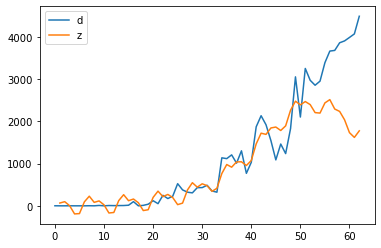

In [138]:
plt.plot(df_diario['case_day'], label = 'd')
plt.plot(df_acumulado['case_day'], label = 'z')
plt.legend()


,country,date,cases,deaths,recoveries,day,case_day,death_day,recovery_day,%var_case_day,...,recoveries_million,avg7_cases,avg7_deaths,avg7_recoveries,avg7_cases_million,avg7_deaths_million,avg7_recoveries_million,perc_death,perc_recovery,active_cases
0,Afghanistan,2020-02-24,1,0,0,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Afghanistan,2020-02-25,1,0,0,2,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Afghanistan,2020-02-26,1,0,0,3,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Afghanistan,2020-02-27,1,0,0,4,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Afghanistan,2020-02-28,1,0,0,5,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8528,Yemen,2020-04-14,1,0,0,5,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8529,Yemen,2020-04-15,1,0,0,6,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8530,Yemen,2020-04-16,1,0,0,7,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8531,Yemen,2020-04-17,1,0,0,8,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
